In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from activation_layers import ReLU, Softmax, Sigmoid
from dense import Dense
from losses import categorical_cross_entropy, categorical_cross_entropy_prime
from network import train, predict
from convolutional import Convolutional
from reshape import Reshape

In [15]:
df = pd.read_csv('chineseMNIST.csv')
df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095,label,character
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九


In [16]:
df_label = df['label']
df_images = df.drop(columns=['label', 'character'])
df_images.shape, df_label.shape

((15000, 4096), (15000,))

In [17]:
print(f"Characters: {df['character'].nunique()}: {list(df['character'].unique())}")
print(f"Numbers: {df['label'].nunique()}: {list(df['label'].unique())}")

Characters: 15: ['九', '十', '百', '千', '万', '亿', '零', '一', '二', '三', '四', '五', '六', '七', '八']
Numbers: 15: [np.int64(9), np.int64(10), np.int64(100), np.int64(1000), np.int64(10000), np.int64(100000000), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]


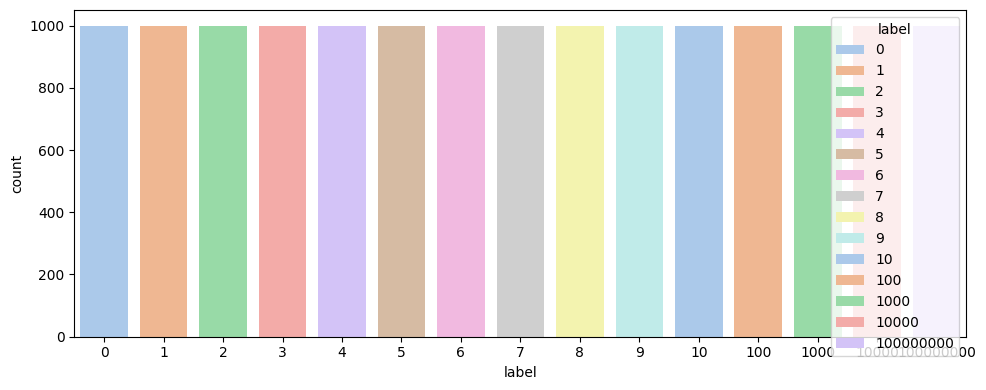

In [18]:
label_counts = df['label'].value_counts().reset_index()
label_counts.columns = ['label', 'count']

# Plot
plt.figure(figsize=(10, 4))
sns.barplot(x='label', y='count', data=label_counts, hue='label', palette='pastel')
plt.tight_layout()
plt.show()

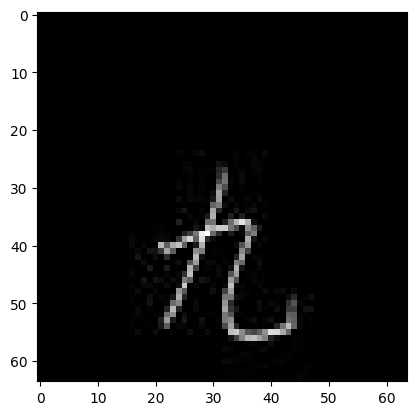

In [19]:
plt.imshow(df_images.iloc[0].values.reshape(64,64), cmap='gray')

In [20]:
def to_categorical(y, num_classes=15):
    one_hot = np.zeros((y.size, num_classes))
    one_hot[np.arange(y.size), y] = 1
    return one_hot

In [21]:
# Step 1: Normalize images
df_images_norm = df_images / 255.0

In [22]:
# Step 2: Flatten images
X = df_images_norm.values.reshape(-1, 64 * 64)  # shape: (num_samples, 4096)

In [23]:
# Step 3: One-hot encode labels
df_label.replace(100, 11, inplace=True)
df_label.replace(1000, 12, inplace=True)
df_label.replace(10000, 13, inplace=True)
df_label.replace(100000000, 14, inplace=True)
y = to_categorical(df_label.values, num_classes=15)  # shape: (num_samples, 15)

In [24]:
# Step 4: Preprocess Data
X = X.reshape(len(X), 1, 64, 64)
y = y.reshape(len(y), 15,)

In [25]:
# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Step 6: Define your network
network = [
    Convolutional((1, 64, 64), 5, 8),
    ReLU(),

    Reshape((8, 60, 60), (8 * 60 * 60,)),

    Dense(8 * 60 * 60, 256),
    ReLU(),

    Dense(256, 15),
    Softmax()
]

# Step 7: Train the network
train(
    network,
    categorical_cross_entropy,
    categorical_cross_entropy_prime,
    X_train,
    y_train,
    epochs=20,
    learning_rate=0.01,
    batch_size=64
)

10/20, error=1.051730


20/20, error=0.473082


In [27]:
# Step 8: Evaluate accuracy
def accuracy(y_true, y_pred):
    pred_labels = np.argmax(y_pred, axis=1)
    true_labels = np.argmax(y_true, axis=1)
    return np.mean(pred_labels == true_labels)

# Predict on test set
predictions = predict(network, X_test)  # X_test shape: (batch_size, features)
acc = accuracy(y_test, predictions)
print(f"Test accuracy: {acc * 100:.2f}%")

Test accuracy: 76.43%


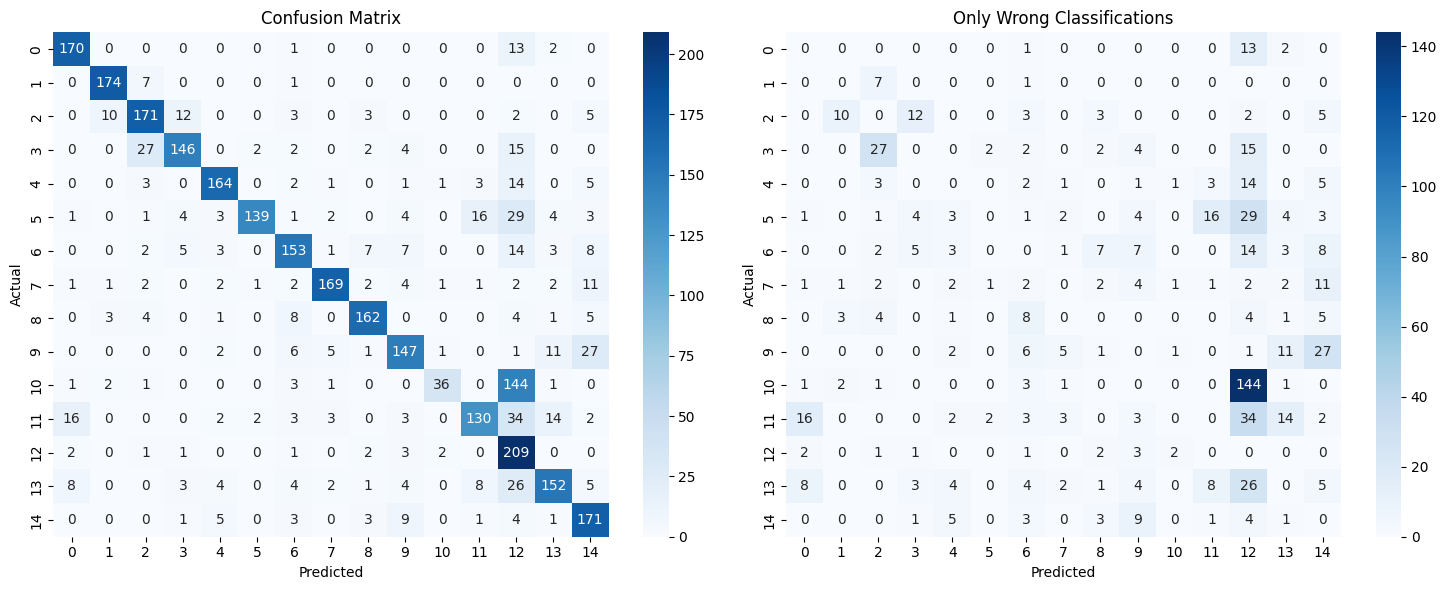

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# y_pred = [np.argmax(predict(network, X_test[:, i])) for i in range(X_test.shape[1])]
# y_true = [np.argmax(y_test[:, i]) for i in range(y_test.shape[1])]

y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)


fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axs[0])
axs[0].set_title('Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')

cm_new = cm.copy()
for i in range(15):
    cm_new[i][i] = 0

sns.heatmap(cm_new, annot=True, fmt="d", cmap="Blues", ax=axs[1])
axs[1].set_title('Only Wrong Classifications')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [29]:
import numpy as np

def save_weights_auto(network, filename="network_weights.npz"):
    data = {}
    for i, layer in enumerate(network):
        for attr in ["weights", "bias", "kernels", "biases"]:
            if hasattr(layer, attr):
                data[f"layer_{i}_{attr}"] = getattr(layer, attr)
    np.savez(filename, **data)

save_weights_auto(network, "model_weights.npz")
